# Experiment #1: LLM Quiz

## Few-shot Prompt

```
You are an expert literary critic with a deep understanding of Persian poetry, its cultural nuances, and its stylistic features. Your task is to analyze a set of poetic options—each option presenting two parts of a couplet—and identify the one option that deviates in conceptual meaning or thematic message from the others. Focus exclusively on the underlying concepts, disregarding stylistic or linguistic differences.

For example:

---
Options:
1. طریق عشق پرآشوب و فتنه است ای دل - بیفتد آن که در این راه با شتاب رود
2. گر نور عشق حق به دل و جانت اوفتد - بالله از آفتاب فلک خوبتر شوی
3. شکوه عشق نگه کن که موی مجنون را - فلک به شعشعه آفتاب، شانه کند
4. فرزانه درآید به پری خانه مقصود - هر کس که در این بادیه دیوانه عشق است

Correct answer: 1

(Option 1 warns against hastily pursuing the turbulent path of love, whereas the other options present love as an uplifting force)

---
Options:
1. شمشیر نیک از آهن بد چون کند کسی؟ - ناکس تربیت نشود ای حکیم کس
2. سگ به دریای هفت گانه بشوی - که چو تر شد پلیدتر باشد
3. ز وحشی نیاید که مردم شود - به سعی اندر او تربیت گم شود
4. سگ اصحاب کهف روزی چند - پی نیکان گرفت و مردم شد

Correct answer: 4

(Option 4 emphasizes the significant impact of upbringing, unlike the other options which imply that upbringing makes little difference)

---
Options:
1. هر چند خوشگوار بود باده غرور - زین می فزون از سنگ نگه دار شیشه را
2. از ساده دلی هر که دهد پند به مغرور - بیدار به افسانه کند خواب گران را
3. کبر مفروش به مردم که به میزان نظر - زود گردد سبک آن کس که بود سنگین تر
4. خاک بر فرقش اگر از کبر سر بالا کند - هر که داند بازگشت او به غیر از خاک نیست

Correct answer: 2

(The meaning of option 2 is the ineffectiveness of giving advice to the arrogant, while the common meaning of the other options is the recommendation to avoid arrogance)
```

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("few-shot-answers.csv")
df.head()

,model_name,question_number,model_answer,completion_tokens
0,google/gemini-2.0-flash-001,21,1.0,2
1,google/gemini-2.0-flash-001,24,2.0,2
2,google/gemini-2.0-flash-001,40,3.0,2
3,google/gemini-2.0-flash-001,42,2.0,2
4,google/gemini-2.0-flash-001,44,3.0,2


In [3]:
with open("../data/correct-answers.json", "r") as f:
    correct_answers = json.load(f)

print({k: correct_answers[k] for k in list(correct_answers)[:5]})

{'1': 1, '2': 4, '3': 3, '4': 3, '5': 2}


In [4]:
def grade_answer(row):
    # Convert the question number from the CSV to string to match the keys in the JSON.
    q_num = str(row['question_number'])
    correct = correct_answers.get(q_num)

    if correct is not None and row['model_answer'] == correct:
        return 'correct'
    else:
        return 'incorrect'

# Apply the function to create a new column "grade".
df['grade'] = df.apply(grade_answer, axis=1)
df.head()

,model_name,question_number,model_answer,completion_tokens,grade
0,google/gemini-2.0-flash-001,21,1.0,2,incorrect
1,google/gemini-2.0-flash-001,24,2.0,2,incorrect
2,google/gemini-2.0-flash-001,40,3.0,2,correct
3,google/gemini-2.0-flash-001,42,2.0,2,correct
4,google/gemini-2.0-flash-001,44,3.0,2,correct


In [5]:
# Group by model_name and calculate the mean where grade is 'correct'
performance = df.groupby('model_name').apply(lambda group: (group['grade'] == 'correct').mean() * 100)

# Convert to a DataFrame and rename the calculated column
performance = performance.reset_index(name="score")

# Sort the performance by score in descending order.
performance.sort_values("score", ascending=False, inplace=True)

# Display the performance DataFrame
performance

/var/folders/9b/1jgyjhd92f1bj5gtpnw2bct00000gn/T/ipykernel_32553/1275346742.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance = df.groupby('model_name').apply(lambda group: (group['grade'] == 'correct').mean() * 100)


,model_name,score
4,google/gemini-2.5-pro-preview-03-25,89.743590
0,anthropic/claude-3.5-sonnet,71.794872
3,google/gemini-2.0-flash-001,66.666667
7,meta-llama/llama-3.3-70b-instruct,64.102564
8,openai/gpt-4o,61.538462
2,deepseek/deepseek-r1,51.282051
5,google/gemma-3-12b-it,43.589744
6,google/gemma-3-27b-it,43.589744
10,openai/o1-mini,43.589744
1,deepseek/deepseek-chat-v3-0324,38.461538


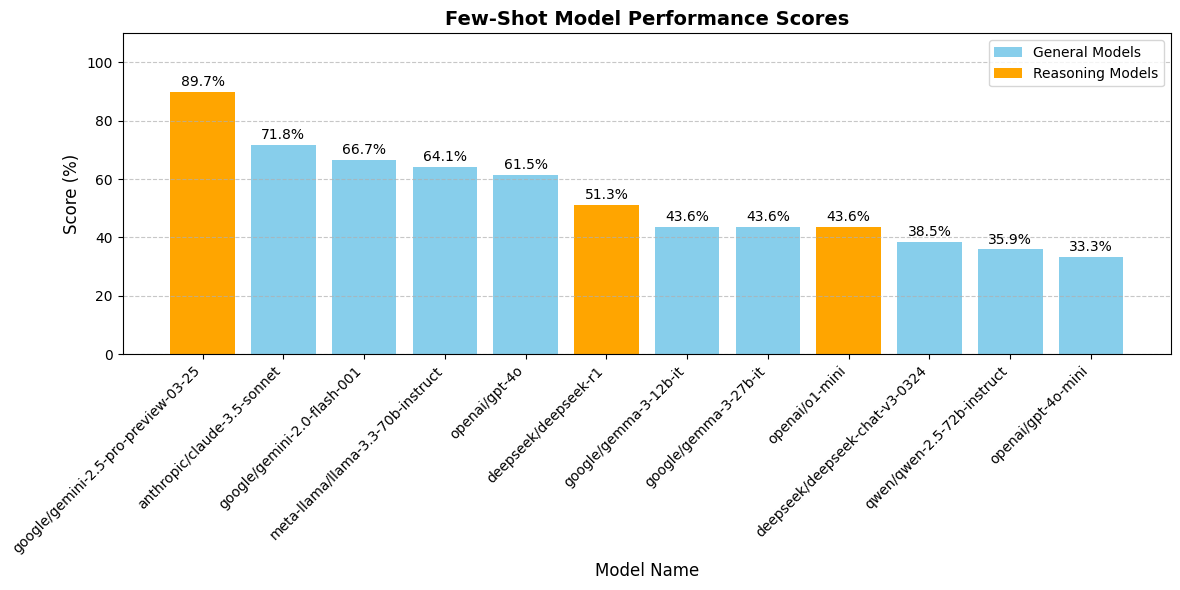

In [6]:
plt.figure(figsize=(12,6))

# Define which models are reasoning models
reasoning_models = {
    "openai/o1-mini",
    "google/gemini-2.5-pro-preview-03-25",
    "deepseek/deepseek-r1"
}

# Assign bar colors: use a different color for reasoning models
bar_colors = ['orange' if model in reasoning_models else 'skyblue'
              for model in performance['model_name']]

bars = plt.bar(performance['model_name'], performance['score'], color=bar_colors)

# Annotate each bar with the score
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Model Name", fontsize=12)
plt.ylabel("Score (%)", fontsize=12)
plt.title("Few-Shot Model Performance Scores", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='General Models'),
    Patch(facecolor='orange', label='Reasoning Models')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()